In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from ydata_profiling import ProfileReport
from sklearn.feature_selection import SelectFromModel
import plotly.express as px  # interactive charts
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from src.exception import CustomException
import os
from src.logger import logging
import sys
from datetime import datetime
from src.utils import DatabaseManager
from src.components.variable import dataBase
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


In [6]:
from src.utils import DatabaseManager

db=DatabaseManager()
df=db.execute_query('select * from marketing_campaign',fetch=True)

In [7]:
df['dt_customer'] = pd.to_datetime(df['dt_customer']) #dt_customer
newest_customer_date = df['dt_customer'].max()
oldest_customer_date = df['dt_customer'].min()
df['Customer_For'] = (newest_customer_date - df['dt_customer']).dt.days

current_year = datetime.now().year
df['Age'] = current_year - df['year_birth']
df['Spent'] = df[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum(axis=1)
df['living_with'] = df['marital_status'].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Single", "Widow": "Single", "YOLO": "Single", "Divorced": "Single", "Single": "Single"})
df['children'] = df['kidhome'] + df['teenhome']
df['Family_Size'] = df['living_with'].replace({"Single": 1, "Partner": 2,"Alone":1})
df['Is_Parent'] = np.where(df['children'] > 0, 1, 0)
df['education'] = df['education'].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors="coerce")
df.loc[(df['Age'] >= 13) & (df['Age'] <= 19), 'AgeGroup'] = 'Teen'
df.loc[(df['Age'] >= 20) & (df['Age']<= 39), 'AgeGroup'] = 'Adult'
df.loc[(df['Age'] >= 40) & (df['Age'] <= 59), 'AgeGroup'] = 'Middle Age Adult'
df.loc[(df['Age'] > 60), 'AgeGroup'] = 'Senior Adult'
df.rename(columns={
    "mntwines": "Wines",
    "mntfruits": "Fruits",
    "mntmeatproducts": "Meat",
    "mntfishproducts": "Fish",
    "mntsweetproducts": "Sweets",
    "mntgoldprods": "Gold"
}, inplace=True)

df.Family_Size=df.Family_Size.astype(int)

In [8]:
data = df.copy()
to_drop = ["marital_status", "dt_customer", "z_costcontact", "z_revenue", "year_birth", "id","AgeGroup","living_with"]
data.drop(to_drop, axis=1, inplace=True)

data.Is_Parent = pd.to_numeric(data.Is_Parent, errors='coerce')

In [9]:
data.dtypes

education               object
income                 float64
kidhome                  int64
teenhome                 int64
recency                  int64
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
Gold                     int64
numdealspurchases        int64
numwebpurchases          int64
numcatalogpurchases      int64
numstorepurchases        int64
numwebvisitsmonth        int64
acceptedcmp3             int64
acceptedcmp4             int64
acceptedcmp5             int64
acceptedcmp1             int64
acceptedcmp2             int64
complain                 int64
response                 int64
Customer_For             int64
Age                      int64
Spent                    int64
children                 int64
Family_Size              int32
Is_Parent                int32
dtype: object

In [10]:
data.education

0           Graduate
1           Graduate
2           Graduate
3           Graduate
4       Postgraduate
            ...     
2235        Graduate
2236    Postgraduate
2237        Graduate
2238    Postgraduate
2239    Postgraduate
Name: education, Length: 2240, dtype: object

In [11]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

data[object_cols]

,education
0,Graduate
1,Graduate
2,Graduate
3,Graduate
4,Postgraduate
...,...
2235,Graduate
2236,Postgraduate
2237,Graduate
2238,Postgraduate


In [12]:
LE = LabelEncoder()
for i in object_cols:
    data[i] = LE.fit_transform(data[i])

In [ ]:
import pandas as pd
import numpy as np
from src.exception import CustomException
import os
from src.logger import logging
import sys
from datetime import datetime
from src.utils import DatabaseManager
from src.components.variable import dataBase
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

class DataCleaning:
    def __init__(self):
        self.db = DatabaseManager()
        self.conn = dataBase.conn

    def process_data_and_reduce_dimensionality(self, filename):

        try:
            logging.info('Database table reading start in data_process.py')
            df=self.db.execute_query(f'select * from {filename}',fetch=True)
            logging.info('In data_process.py database table converted into df')

        except Exception as e:
            logging.info('Exception occurred at data_process.py in table reading from db stage')
            raise CustomException(e,sys)

        # Process df data
        df['dt_customer'] = pd.to_datetime(df['dt_customer']) #dt_customer
        newest_customer_date = df['dt_customer'].max()
        oldest_customer_date = df['dt_customer'].min()
        df['Customer_For'] = (newest_customer_date - df['dt_customer']).dt.days

        current_year = datetime.now().year
        df['Age'] = current_year - df['year_birth']
        df['Spent'] = df[['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']].sum(axis=1)
        df['living_with'] = df['marital_status'].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Single", "Widow": "Single", "YOLO": "Single", "Divorced": "Single", "Single": "Single"})
        df['children'] = df['kidhome'] + df['teenhome']
        df['Family_Size'] = df['living_with'].replace({"Single": 1, "Partner": 2})
        df['Is_Parent'] = np.where(df['children'] > 0, 1, 0)
        df['education'] = df['education'].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
        df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors="coerce")
        # df.loc[(df['Age'] >= 13) & (df['Age'] <= 19), 'AgeGroup'] = 'Teen'
        # df.loc[(df['Age'] >= 20) & (df['Age']<= 39), 'AgeGroup'] = 'Adult'
        # df.loc[(df['Age'] >= 40) & (df['Age'] <= 59), 'AgeGroup'] = 'Middle Age Adult'
        # df.loc[(df['Age'] > 60), 'AgeGroup'] = 'Senior Adult'
        df.rename(columns={
            "mntwines": "Wines",
            "mntfruits": "Fruits",
            "mntmeatproducts": "Meat",
            "mntfishproducts": "Fish",
            "mntsweetproducts": "Sweets",
            "mntgoldprods": "Gold"
        }, inplace=True)


        filename2 = 'Without_encoding'

        try:
            self.db.execute_values(df, filename2)
            logging.info('DataFrame data values have been successfully uploaded to the database table')

        except Exception as e:
            logging.info('Exception occurred at data_process.py file during creating table/execute_value')
            raise CustomException(e, sys)


        data = df.copy()
        to_drop = ["marital_status", "dt_customer", "z_costcontact", "z_revenue", "year_birth", "id"]
        data.drop(to_drop, axis=1, inplace=True)

        data.Is_Parent = pd.to_numeric(data.Is_Parent, errors='coerce')



        #Get list of categorical variables
        s = (data.dtypes == 'object')
        object_cols = list(s[s].index)

        LE = LabelEncoder()
        for i in object_cols:
            data[i] = LE.fit_transform(data[i])
            
        print("All features are now numerical")


        
        filename1 = 'cleaned_data'

        try:
            # self.db.create_table(data, filename1)
            # logging.info(f'Successfully created table in the database table name: {filename1}')



            self.db.execute_values(data, filename1)
            logging.info('DataFrame data values have been successfully uploaded to the database table')

        except Exception as e:
            logging.info('Exception occurred at data_process.py file during creating table/execute_value')
            raise CustomException(e, sys)

        return filename1,filename2

# data_transformer = DataTransformationConfig()

# # Step 2: Load your data into a pandas DataFrame
# # Assuming you have your data in a CSV file named 'customer_data.csv'
# db=DatabaseManager()
# customer_data = db.execute_query('select * from marketing_campaign',fetch=True)

# # Step 3: Call the process_data_and_reduce_dimensionality method and pass the DataFrame
# filename1= data_transformer.process_data_and_reduce_dimensionality(customer_data)

# df1=db.execute_query(f'select * from {filename1}',fetch=True)
# logging.info(f'file names is : {filename1}')
# logging.info(f'df1: \n {df1.head()}')

In [52]:
from src.utils import DatabaseManager

db=DatabaseManager()
df=db.execute_query('select * from merge_table',fetch=True)

In [53]:
import seaborn as sns

In [54]:
df = df[df.age < 100]
df = df[df.income < 120000]

Text(0, 0.5, 'income')

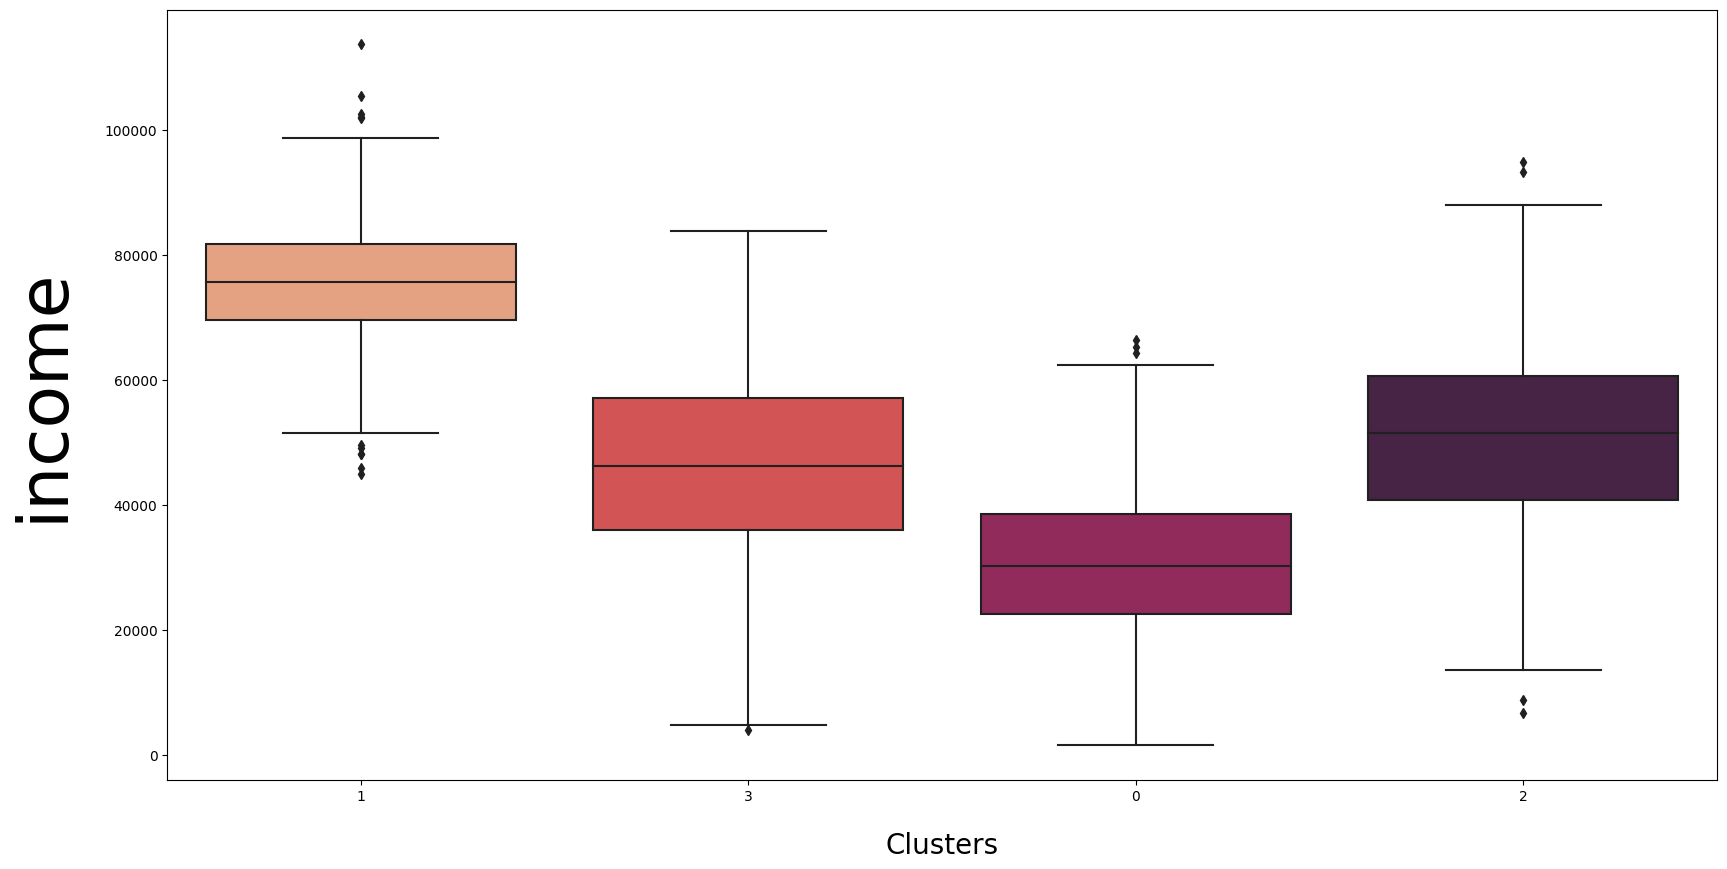

In [55]:
#Income
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'income',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('income', fontsize=50, labelpad=20)

Text(0, 0.5, 'Spendings')

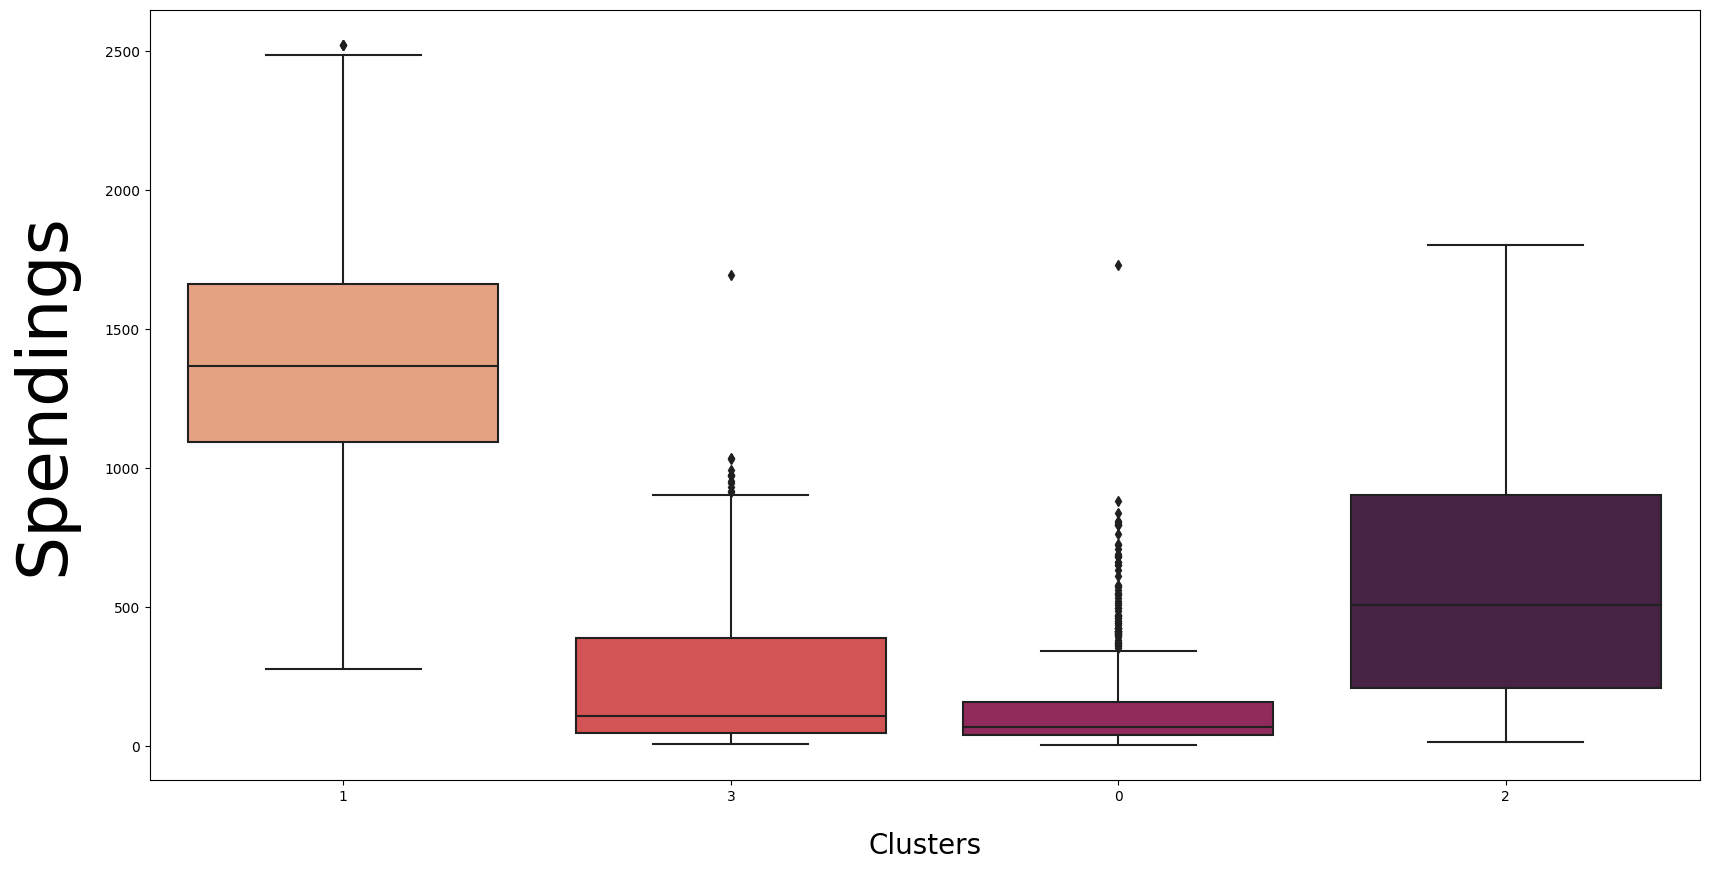

In [56]:
#Total Spending
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'spent',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Spendings', fontsize=50, labelpad=20)

In [57]:
df

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters
0,0.0,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,66,1617,0.0,0,1,0.0,1
1,0.0,46344.0,1,1,38,11,1,6,2,1,...,0,0,113,69,27,0.0,2,1,1.0,3
2,0.0,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,58,776,1.0,0,2,0.0,1
3,0.0,26646.0,1,0,26,11,4,20,10,3,...,0,0,139,39,53,1.0,1,2,1.0,0
4,1.0,58293.0,1,0,94,173,43,118,46,27,...,0,0,161,42,422,1.0,1,2,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.0,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,56,1341,1.0,1,2,1.0,1
2236,1.0,64014.0,2,1,56,406,0,30,0,0,...,0,0,19,77,444,1.0,3,2,1.0,3
2237,0.0,56981.0,0,0,91,908,48,217,32,12,...,0,0,155,42,1241,0.0,0,1,0.0,1
2238,1.0,69245.0,0,1,8,428,30,214,80,30,...,0,0,156,67,843,1.0,1,2,1.0,3


Text(0, 0.5, 'Month Since Customer')

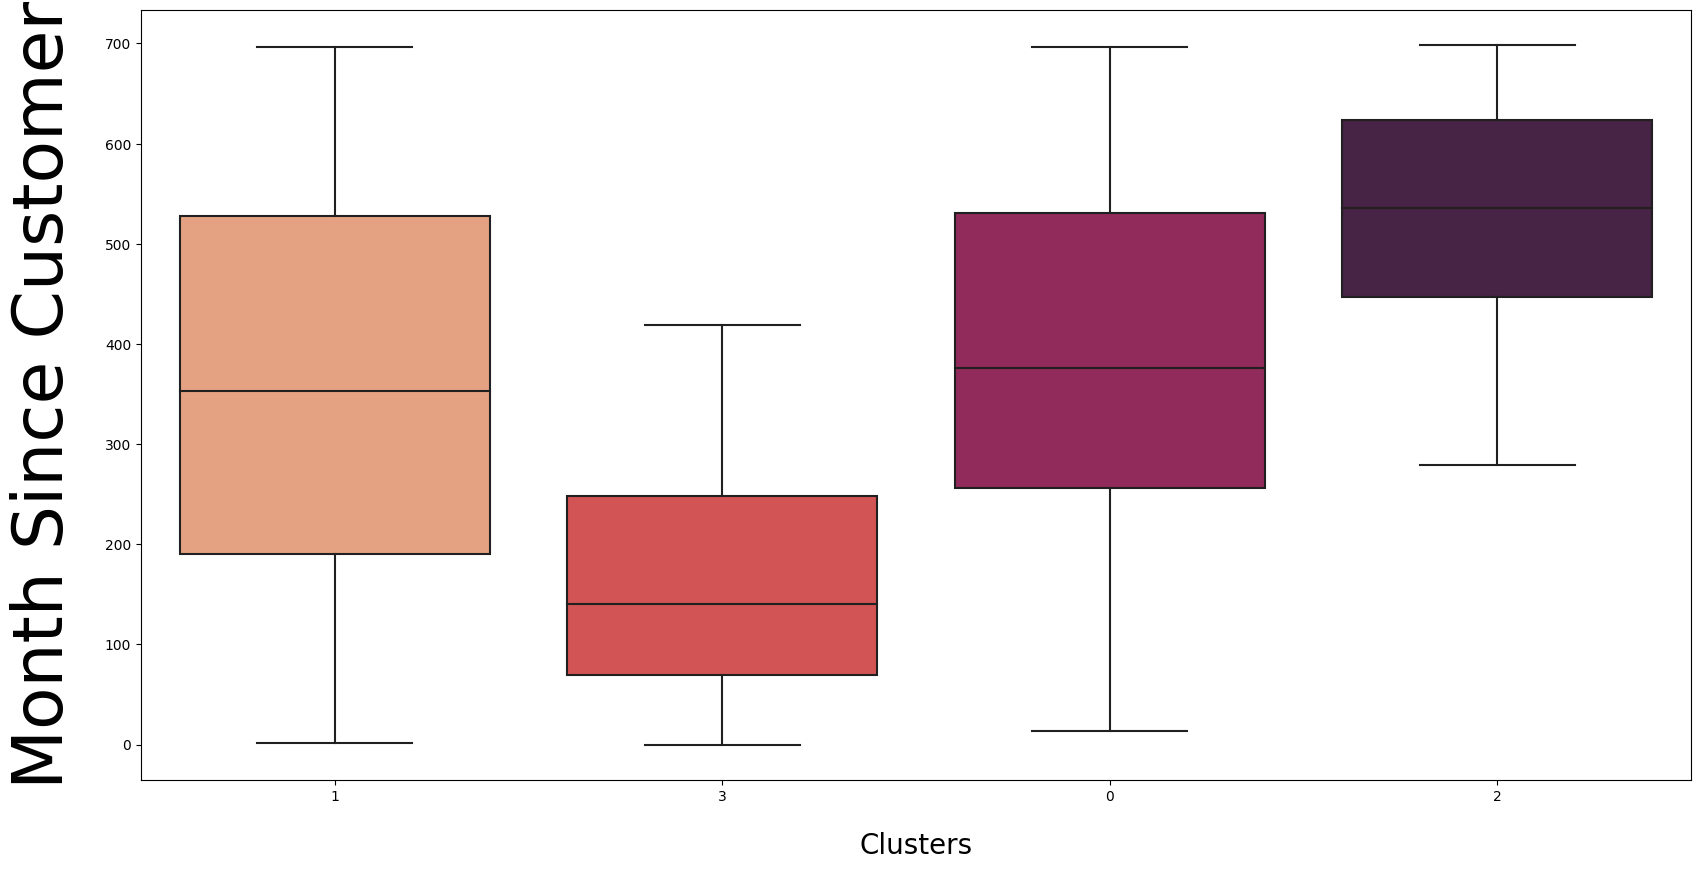

In [58]:
#Month Since Customer
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'customer_for',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Month Since Customer', fontsize=50, labelpad=20)

Text(0, 0.5, 'Age')

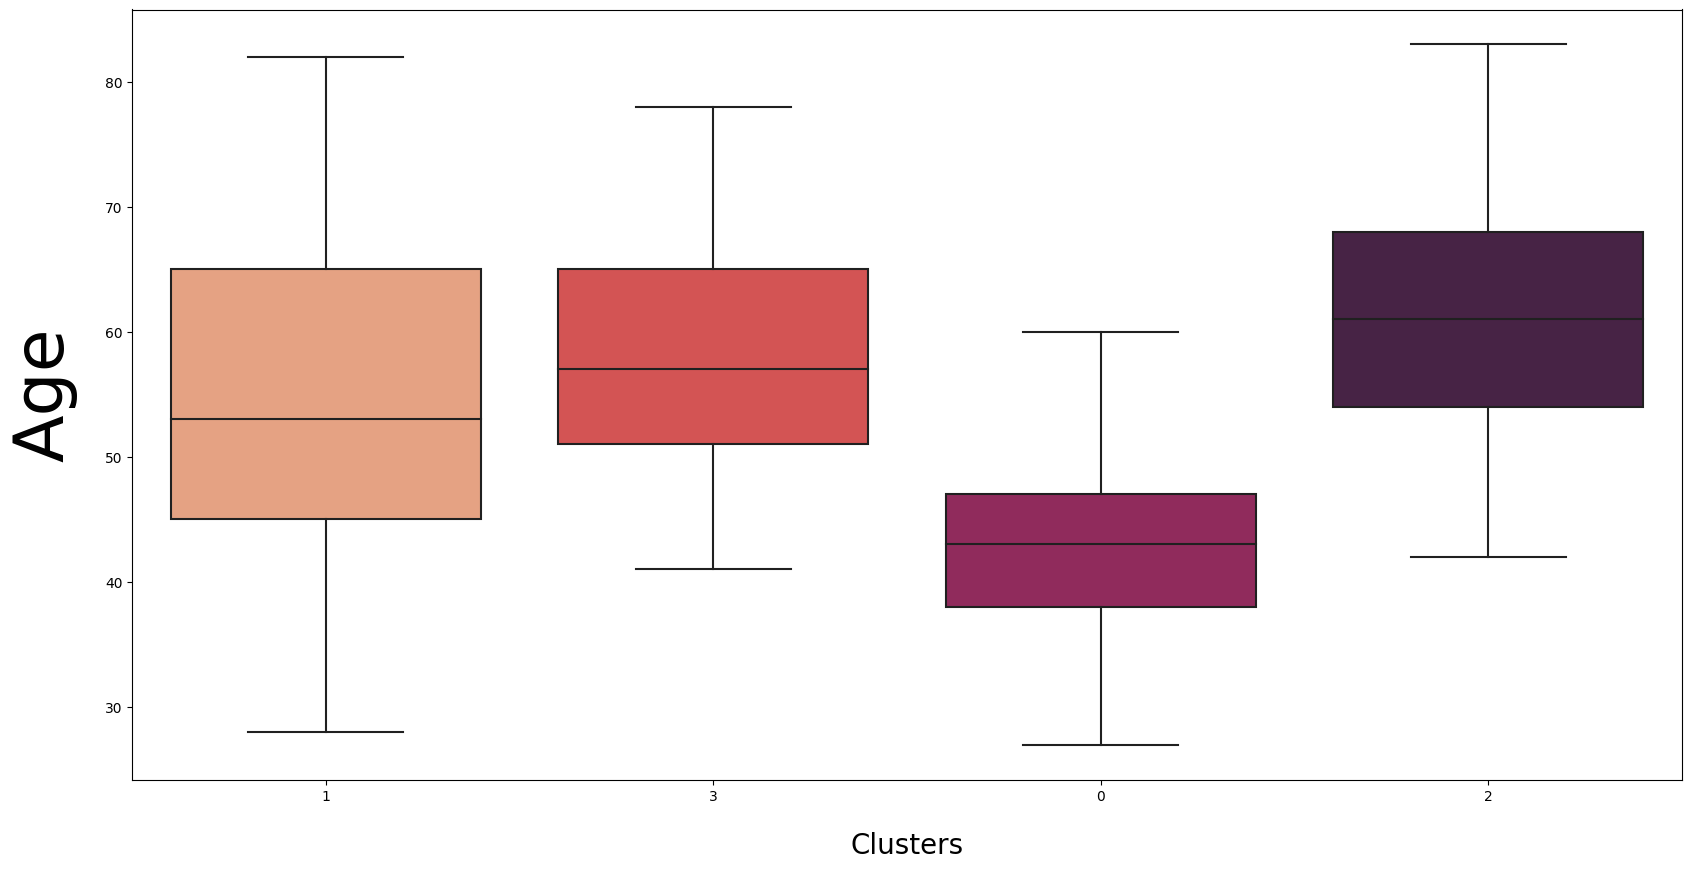

In [59]:
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'age',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Age', fontsize=50, labelpad=20)

Text(0, 0.5, 'No. of Children')

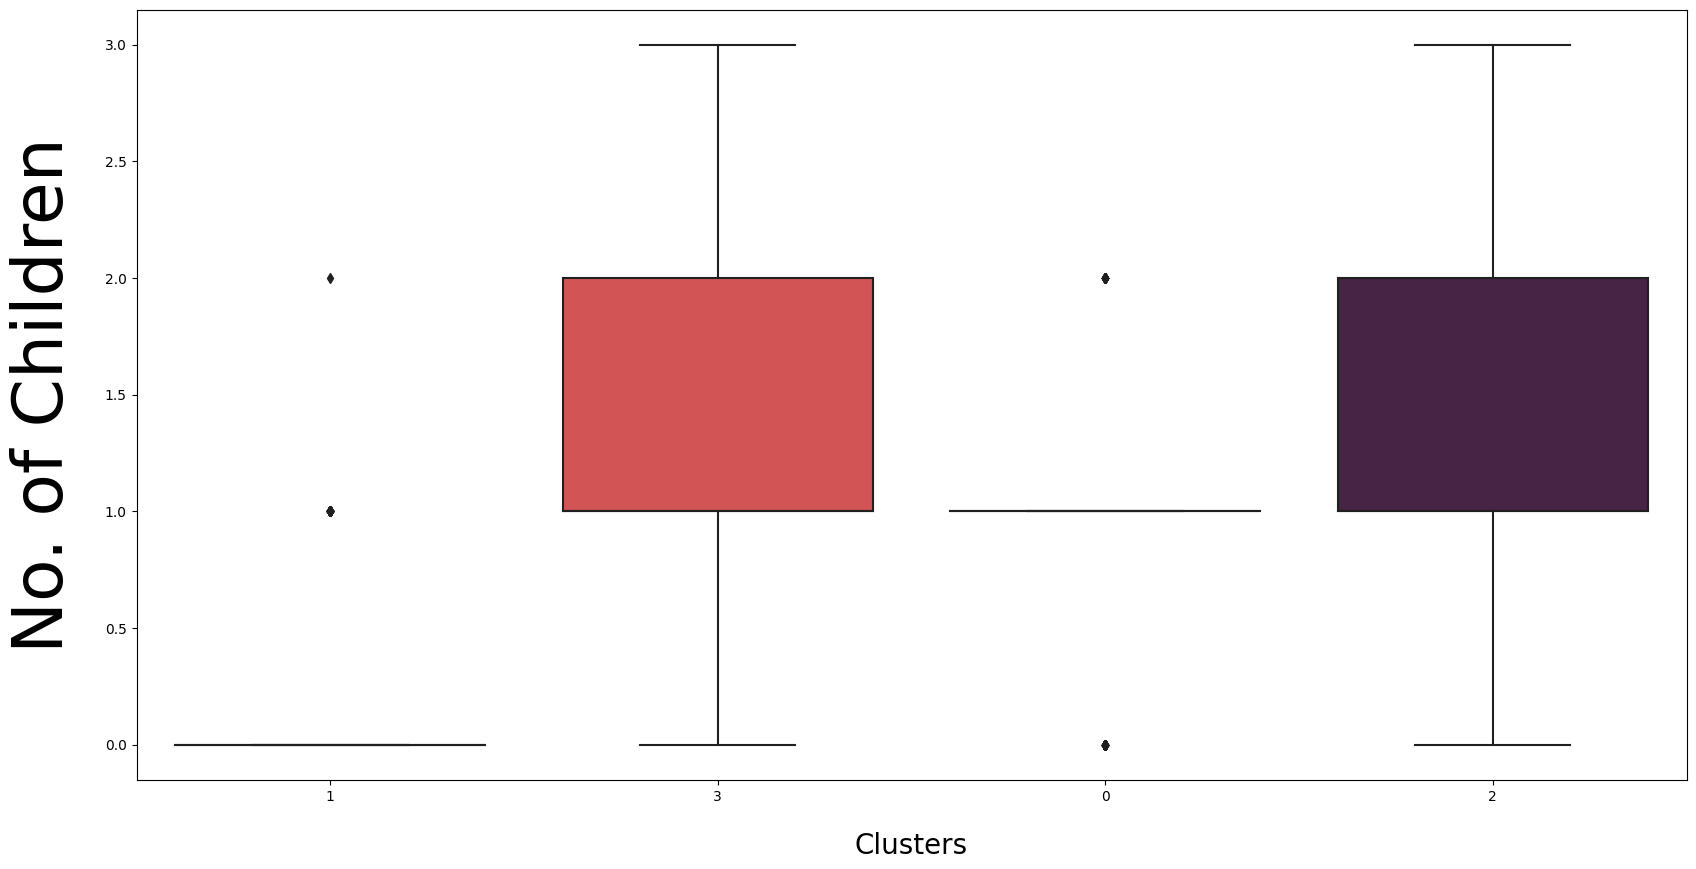

In [60]:
plt.figure(figsize=(20,10))

sns.boxplot(data=df, x='clusters', y = 'children',palette='rocket_r')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('No. of Children', fontsize=50, labelpad=20)

In [71]:
df = df.replace({'clusters': {'0': 'Bronze', '3': 'Platinum', '2': 'Silver', '1': 'Gold'}})


In [72]:
df

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters
0,0.0,58138.0,0,0,58,635,88,546,172,88,...,0,1,663,66,1617,0.0,0,1,0.0,Gold
1,0.0,46344.0,1,1,38,11,1,6,2,1,...,0,0,113,69,27,0.0,2,1,1.0,Platinum
2,0.0,71613.0,0,0,26,426,49,127,111,21,...,0,0,312,58,776,1.0,0,2,0.0,Gold
3,0.0,26646.0,1,0,26,11,4,20,10,3,...,0,0,139,39,53,1.0,1,2,1.0,Bronze
4,1.0,58293.0,1,0,94,173,43,118,46,27,...,0,0,161,42,422,1.0,1,2,1.0,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,0.0,61223.0,0,1,46,709,43,182,42,118,...,0,0,381,56,1341,1.0,1,2,1.0,Gold
2236,1.0,64014.0,2,1,56,406,0,30,0,0,...,0,0,19,77,444,1.0,3,2,1.0,Platinum
2237,0.0,56981.0,0,0,91,908,48,217,32,12,...,0,0,155,42,1241,0.0,0,1,0.0,Gold
2238,1.0,69245.0,0,1,8,428,30,214,80,30,...,0,0,156,67,843,1.0,1,2,1.0,Platinum


In [24]:
df['children'].value_counts()

children
1    1112
0     628
2     415
3      50
Name: count, dtype: int64

In [25]:
children_counts = df['children'].value_counts()

fig = px.pie(children_counts, 
             values = children_counts.values, 
             names = children_counts.index,
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont_size=20,
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show()

In [26]:
df1=df[df.clusters=='1']
df1

,education,income,kidhome,teenhome,recency,wines,fruits,meat,fish,sweets,...,complain,response,customer_for,age,spent,living_with,children,family_size,is_parent,clusters


In [27]:
cluster_purchases=df[['numdealspurchases','numwebpurchases','numcatalogpurchases','numstorepurchases','numwebvisitsmonth']]
cluster_purchases

,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth
0,3,8,10,4,7
1,2,1,1,2,5
2,1,8,2,10,4
3,2,2,0,4,6
4,5,5,3,6,5
...,...,...,...,...,...
2235,2,9,3,4,5
2236,7,8,2,5,7
2237,1,2,3,13,6
2238,2,6,5,10,3


In [28]:
import plotly.express as px

# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cluster_purchases.index,
             y=cluster_purchases.values,
             color=cluster_purchases.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'Clusters', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cluster_purchases.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


ValueError: Data must be 1-dimensional, got ndarray of shape (2205, 5) instead

In [ ]:
cam=df1[['acceptedcmp1', 'acceptedcmp2', 'acceptedcmp3', 'acceptedcmp4','acceptedcmp5', 'response']].sum()
cam

acceptedcmp1    128
acceptedcmp2     21
acceptedcmp3     50
acceptedcmp4     87
acceptedcmp5    156
response        168
dtype: int64

In [ ]:
# Assuming cluster_purchases is your DataFrame with cluster-wise purchases
fig = px.bar(x=cam.index,
             y=cam.values,
             color=cam.index,
             color_discrete_sequence=['#dc4c4c', '#157394', '#589cb4', '#bcb4ac', '#3c444c'],
             labels={'x': 'campaign', 'y': 'Purchases'},
             barmode='group',  # Set barmode to 'group' for grouped bars
             text=cam.values,  # Display the values on top of bars
             height=550,  # Adjust the height of the graph
             width=800)  # Adjust the width of the graph

fig.update_xaxes(categoryorder='total ascending', tickangle=45, title_font=dict(size=18))  # Sort, angle, and format x-axis labels
fig.update_yaxes(title_font=dict(size=18))  # Format y-axis label
fig.update_layout(xaxis_title_font=dict(size=20), yaxis_title_font=dict(size=20), plot_bgcolor='#f5f5f5')  # Customize fonts and plot background
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside', showlegend=False)  # Format text on bars and remove legend
fig.update_layout(bargap=0, bargroupgap=0)
fig.update_layout(paper_bgcolor='#1f2630',font_color='white',plot_bgcolor='#1f2630')
fig.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

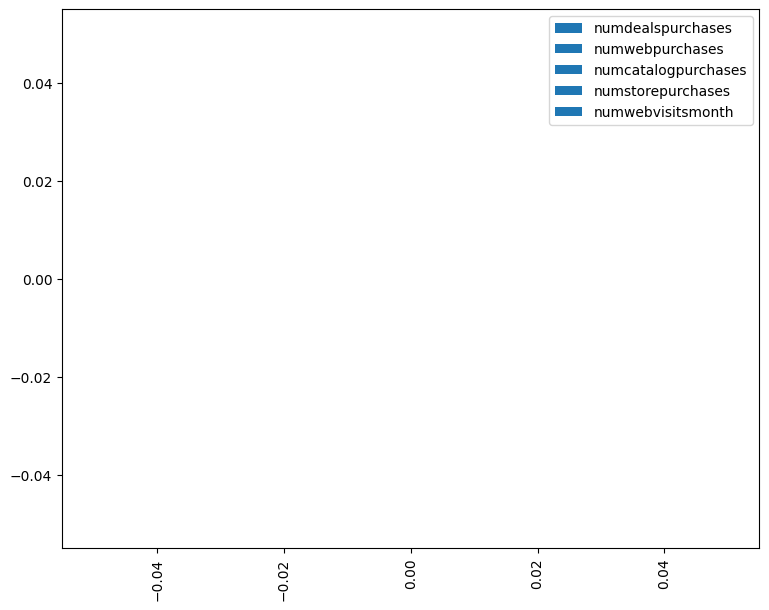

In [29]:
cluster_purchases = df1.groupby('clusters')[['numdealspurchases', 'numwebpurchases', 'numcatalogpurchases',
                                                  'numstorepurchases', 'numwebvisitsmonth']].sum()

cluster_purchases.plot(kind='bar', color=['#dc4c4c','#157394','#589cb4','#bcb4ac','#3c444c'], figsize=(9,7))

plt.title('Purchasing Habits by Cluster')
plt.xlabel('Clusters', fontsize=20, labelpad=20)
plt.ylabel('Purchases', fontsize=20, labelpad=20)
plt.xticks(rotation=0, ha='center')

In [ ]:
income=df[df.clusters=='1'].income.mean()

AttributeError: 'DataFrame' object has no attribute 'clusters'

In [ ]:
((55000-income)/income)*100

NameError: name 'income' is not defined

In [30]:
df.income.mean()-40000

11622.094784580499

In [31]:
result = df.groupby('clusters')['income'].agg(
    mean='mean',
    median='median',
    min='min',
    max='max'
).reset_index()

result

,clusters,mean,median,min,max


<Axes: xlabel='income', ylabel='Count'>

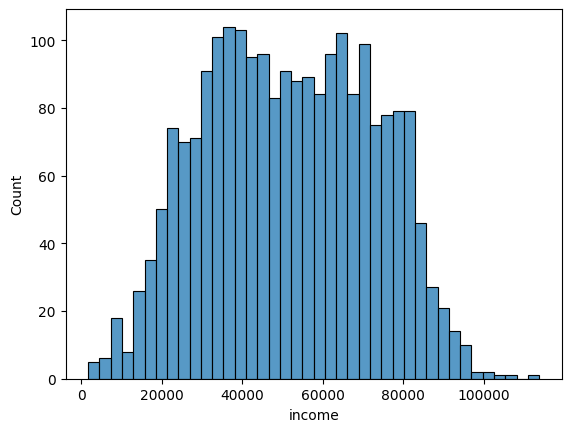

In [32]:
import seaborn as sns
sns.histplot(df.income[df.income<600000],bins=40)

In [33]:
df.income=df.income[df.income<200000]

In [34]:
maritalspending = customer.groupby('Marital_Status')['TotalSpendings'].mean().sort_values(ascending=False)
maritalspending_df = pd.DataFrame(list(maritalspending.items()), columns=['Marital Status', 'Average Spending'])

plt.figure(figsize=(13,5))
sns.barplot(data = maritalspending_df, x="Average Spending", y="Marital Status", palette='rocket')

plt.xticks( fontsize=12)
plt.yticks( fontsize=12)
plt.xlabel('Average Spending', fontsize=13, labelpad=13)
plt.ylabel('Marital Status', fontsize=13, labelpad=13)

NameError: name 'customer' is not defined

In [35]:
df.family_size.replace({1:'Single',2:'Partner'},inplace=True)

In [36]:
fig = px.sunburst(df, path=['family_size','education', 'children'], values='spent', color='education')
fig.show()

In [37]:
df=df[df.clusters=='0']

In [38]:
fig = px.scatter(df, x='spent', y='income',size='children', color='family_size',
                 hover_name='income')

fig